In [1]:
import warnings
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from pmdarima import auto_arima
from sklearn import metrics
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
warnings.filterwarnings("ignore")

/Users/gracelegrand/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/Users/gracelegrand/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/gracelegrand/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize tho

In [2]:
cwd = os.getcwd()

# file path to ETF data
file_path = cwd+'/archive/Data/ETFs'

# retrieve IWF data and place into a dataframe
df = pd.read_csv(file_path+'/iwf.us.txt', delimiter=',', parse_dates=['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2005-02-25,43.536,43.874,43.443,43.799,2513391,0
1,2005-02-28,43.837,43.837,43.373,43.628,618327,0
2,2005-03-01,43.582,43.915,43.582,43.915,1187309,0
3,2005-03-02,43.752,44.081,43.600,43.891,456970,0
4,2005-03-03,44.071,44.071,43.600,43.827,531643,0


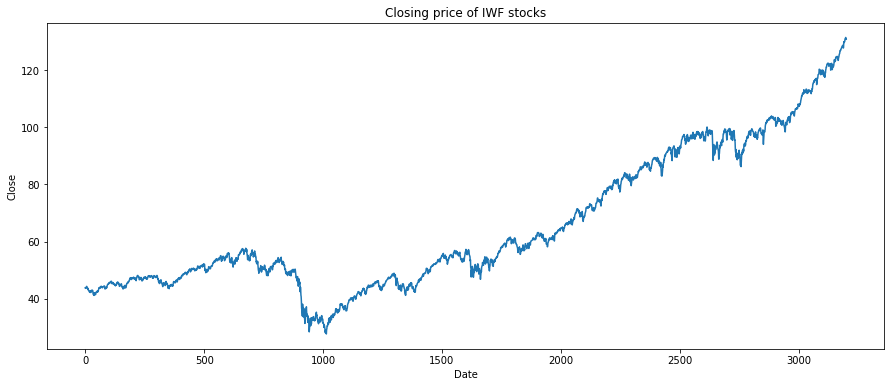

In [3]:
# perform some basic EDA using line, histogram and kernel density estimation of the closing price

# Line Plot
df["Close"].plot(figsize=(15, 6))
plt.xlabel("Date")
plt.ylabel("Close")
plt.title("Closing price of IWF stocks")
plt.show()

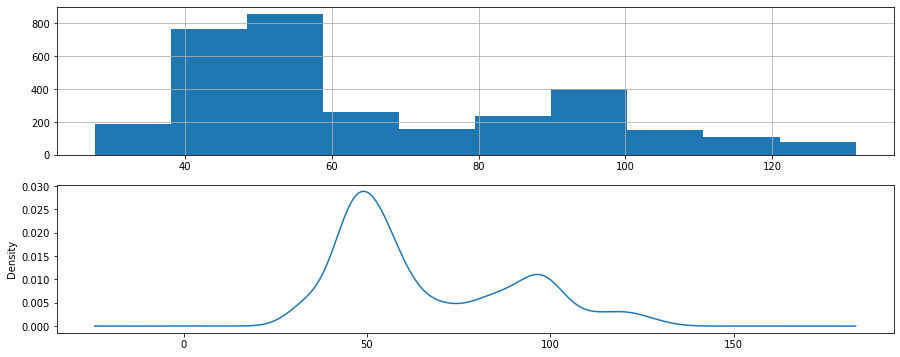

In [4]:
# histogram and KDE plot
plt.figure(1, figsize=(15,6))
plt.subplot(211)
df["Close"].hist()
plt.subplot(212)
df["Close"].plot(kind='kde')
plt.show()


In [5]:
# Define the time-series evaluation function as follows
def timeseries_evaluation_metrics_func(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print('Evaluation metric results:-')
    print(f'MSE is : {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MSE is : {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE is : {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE is : {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R2 is : {metrics.r2_score(y_true, y_pred)}',end='\n\n')
    
# Define Augmented Dickey Fuller Test function as follows
def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Results of Dickey-Fuller Test for column: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Reject the null hypothesis")
        print("Data is stationary")
    else:
        print("Conclusion:====>")
        print("Fail to reject the null hypothesis")
        print("Data is non-stationary")

## Model Training
Model training will be done for only the closing prices of the stock

In [6]:
# Train will have all data for the 2016 and up to the last month 2017 and 
# test will have it for the last month of 2017
X = df[['Close']]
train, test =  X[2731:3171], X[3171: ]



In [7]:
# The pmdarima module will help us identify p, d, and q without the hassle of looking at the plot
stepwise_model = auto_arima(train,start_p=1, start_q=1,
    max_p=7, max_q=7, seasonal=False,
    d=None, trace=True,error_action='ignore',suppress_warnings=True, stepwise=True)
stepwise_model.summary()


Fit ARIMA: order=(1, 1, 1); AIC=944.079, BIC=960.417, Fit time=0.083 seconds
Fit ARIMA: order=(0, 1, 0); AIC=942.901, BIC=951.070, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=942.377, BIC=954.630, Fit time=0.014 seconds
Fit ARIMA: order=(0, 1, 1); AIC=942.411, BIC=954.664, Fit time=0.013 seconds
Fit ARIMA: order=(2, 1, 0); AIC=944.351, BIC=960.689, Fit time=0.026 seconds
Fit ARIMA: order=(2, 1, 1); AIC=942.661, BIC=963.083, Fit time=0.300 seconds
Total fit time: 0.443 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  439
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -468.188
Method:                       css-mle   S.D. of innovations              0.703
Date:                Wed, 18 Aug 2021   AIC                            942.377
Time:                        16:24:23   BIC                            954.630
Sample:                             1   HQIC                           947.211
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0673      0.031      2.159      0.031       0.006       0.128
ar.L1.D.y     -0.0757      0.048     -1.591      0.112      -0.169       0.018
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1          -13.2159           +0.0000j           13.2159            0.5000
-----------------------------------------------------------------------------
"""

In [13]:
forecast,conf_int = stepwise_model.predict(n_periods=30,return_conf_int=True)
forecast = pd.DataFrame(forecast,columns=['close_pred'])
df_conf = pd.DataFrame(conf_int,columns= ['Lower_bound','Upper_bound'])
df_conf["new_index"] = range(3171, 3201) # change the new index range
df_conf = df_conf.set_index("new_index")
timeseries_evaluation_metrics_func(test, forecast)


Evaluation metric results:-
MSE is : 7.116425504512619
MSE is : 2.41518927190347
RMSE is : 2.6676629293283325
MAPE is : 1.8686404308346876
R2 is : -1.510328442460425



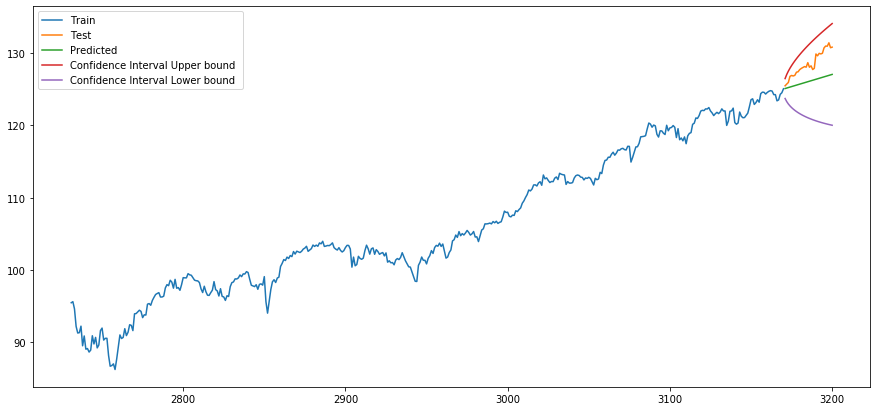

In [16]:
forecast["new_index"] = range(3171, 3201) # chane forecast range
forecast = forecast.set_index("new_index")

#Plot the results with confidence bounds, as shown here:
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
plt.rcParams["figure.figsize"] = [15,7]
plt.plot( train, label='Train ')
plt.plot(test, label='Test ')
plt.plot(forecast, label='Predicted ')
plt.plot(df_conf['Upper_bound'], label='Confidence Interval Upper bound ')
plt.plot(df_conf['Lower_bound'], label='Confidence Interval Lower bound ')
plt.legend(loc='best')
plt.show()




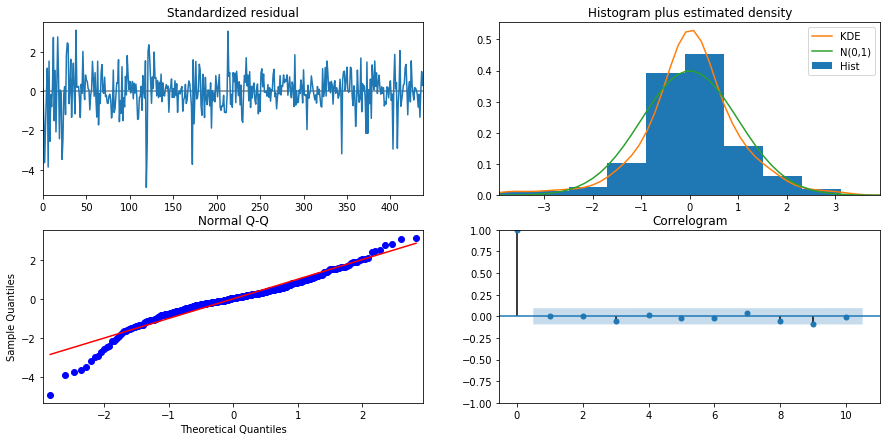

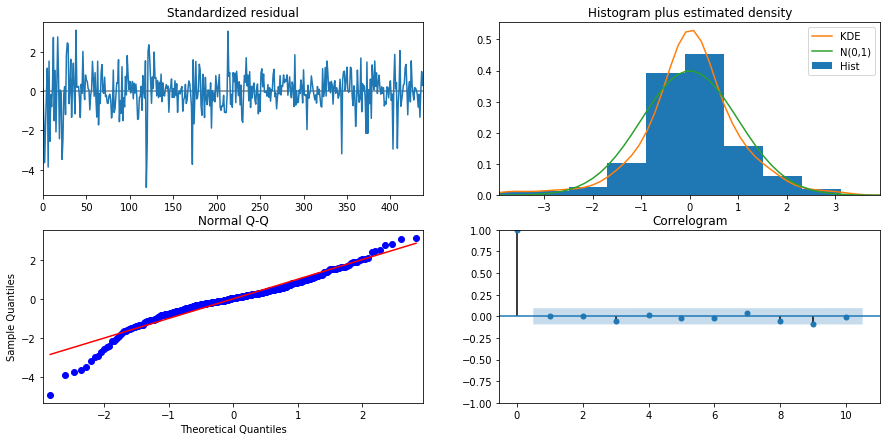

In [10]:
# Diagnostic Plot
stepwise_model.plot_diagnostics()